In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

In previous work, data was scraped from over 7,000 bottles of Syrah from the website Wine Enthusiast. The top 3 Syrah growing regions were identified as the Columbia Valley, Central Coast of California, and Sonoma Valley. Monthly weather data from the years 1994-present were pulled from the API of National Oceanic and Atmospheric Administration for these three regions. The goal was to use this weather data (monthly average temperatures and monthly precipitation) to predict the quality of wines grown in each region each year. 

Previous machine learning attempts used linear regressions to predict the rating of the wine. All of the wine ratings from a given region in a given year were averaged to give a representative rating of the region for a given year. The simple models did not lend much insight into the important weather factors affecting wine quality. Current work in this notebook hopes to use a more complicated model, as well as the totality of the data rather than region averages to better understand the relationship between weather and wine quality. 

Previous work and data sources can be found here: https://github.com/lamontal/WineScraping

Specific notebooks of interest:

Scraping wine data: https://github.com/lamontal/WineScraping/blob/master/WineScraping-Multpage.ipynb

Pulling from NOAA APi: https://github.com/lamontal/WineScraping/blob/master/NOAA_APIquery.ipynb

Cleaning weather data: https://github.com/lamontal/WineScraping/blob/master/WeatherProcessing_forML_AvgPrecp.ipynb

Data Analysis: https://github.com/lamontal/WineScraping/blob/master/WineAnalysis.ipynb

Prior Machine Learning: https://github.com/lamontal/WineScraping/blob/master/ML_Tests-AvgPrecp-TrainTest.ipynb

### Reading in data

In [127]:
#Reading necessary data files
df= pd.read_csv("2nd_fullscrape_clean.csv", index_col= 0, encoding='latin-1')
sono= pd.read_csv("Sonoma_month_AvgPrecp.csv", index_col=0)
coast= pd.read_csv("Coast_month_AvgPrecp.csv", index_col=0)
valley= pd.read_csv("Valley_month_AvgPrecp.csv", index_col=0)



In [92]:
#separating data by the 3 most popular wine growing regions
sonodata = df[(data["Location"] == "Sonoma") & (df["Year"] > 1993) ]
coastdata = df[(data["Location"] == "Central Coast") & (df["Year"] > 1993) ]
valleydata = df[(data["Location"] == "Columbia Valley") & (df["Year"] > 1993) ]

In [95]:
#merging weather data with wine data

finalsono = sonodata.join(sono, "Year")
finalcoast = coastdata.join(coast, "Year")
finalvalley = valleydata.join(valley, "Year")
allfinal = pd.concat([finalsono,finalcoast,finalvalley])

In [139]:

dfs = [finalsono, finalcoast, finalvalley, allfinal ]

### Random forest regression

Random forest regression was selected because of its robustness, and the ability to clearly see the relative importance of each feature to the model. <br>

For each wine, there are 24 features: the average temperature of each month and the total precipiation for each month

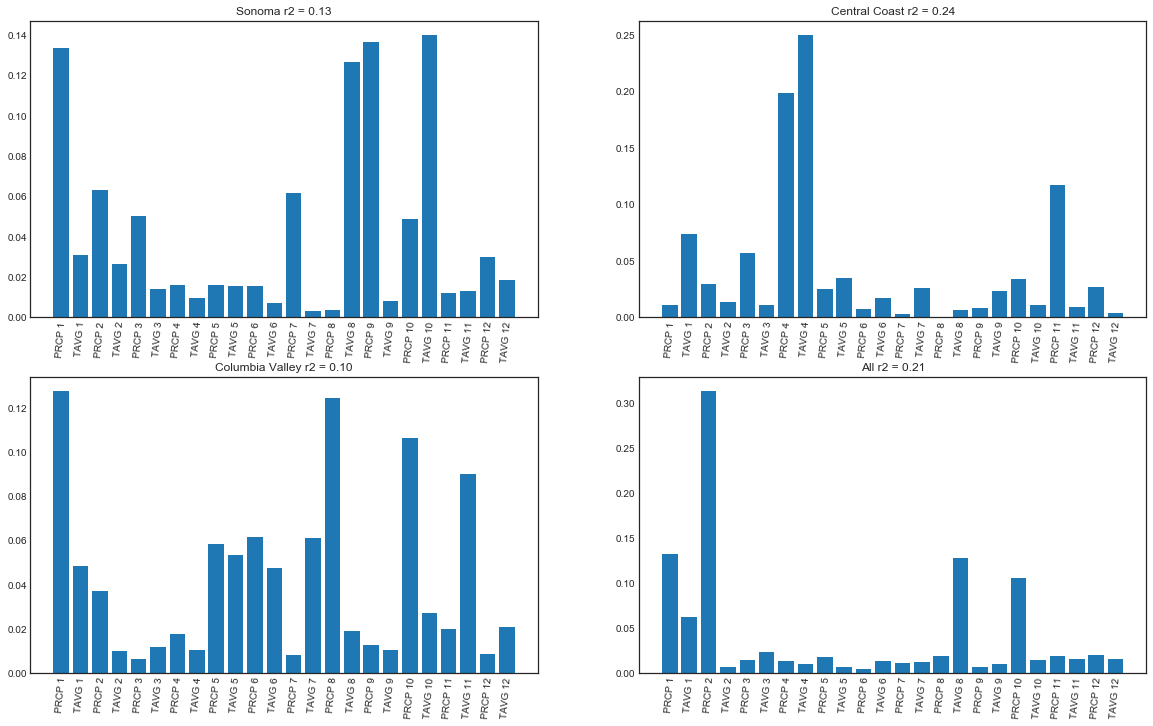

In [142]:
plt.close("all")

fig, axes = plt.subplots(2,2 , figsize = (20,12))
flatax = axes.flatten()
for number, df in enumerate(dfs):
    X = df.iloc[:,5:] #slices of dataframe for machine learning
    y = df.iloc[:,2]
    
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0) #Filling in NaNs with the mean of the column
    imp.fit(X)  #Filling in NaNs with the mean of the column
    X = imp.transform(X)
    
    scaler = StandardScaler() #scaling features 
    X = scaler.fit_transform(X)
    
    
    rf = RandomForestRegressor(n_estimators= 100, max_features=24)
    rf.fit(X,y)
    pred = rf.predict(X)
    
    importances = rf.feature_importances_
    x_values = list(range(len(importances)))
    labels = list(df.iloc[:,5:])
    
    flatax[number].bar(x_values, importances, orientation = 'vertical')
    flatax[number].set_xticks(np.arange(len(importances)))
    flatax[number].set_xticklabels(labels, rotation = 85)
    
    flatax[number].set_title("{0} r2 = {1:.2f}" .format(df.iloc[0,1],r2_score(y,pred)))
flatax[3].set_title("All r2 = {0:.2f}" .format(r2_score(y,pred)) )   
plt.show()

Plots of the relative feature importances to the random forest regression model for each region and all 3 regions combined. The numbers on the x axis correspond to the months of the year. 

When all the wine data for a region is used, the fits are rather poor as indicated by the low R2 values and no discernible insights are seen in the feature importances.

### Using yearly averages for each location instead of each individual wine

The rating data has a wide spread which is not surprising given the drastic differences in the cost of the wine. This might be causing a problem as the weather data is pulled from only one zip code in each region which can be very large. Some wine might be exposed to drastically different temperatures/precipiation than the weather data it is trained on. Training instead on an average of the wine from a given region in a given year, might better make the weather data more representative. 

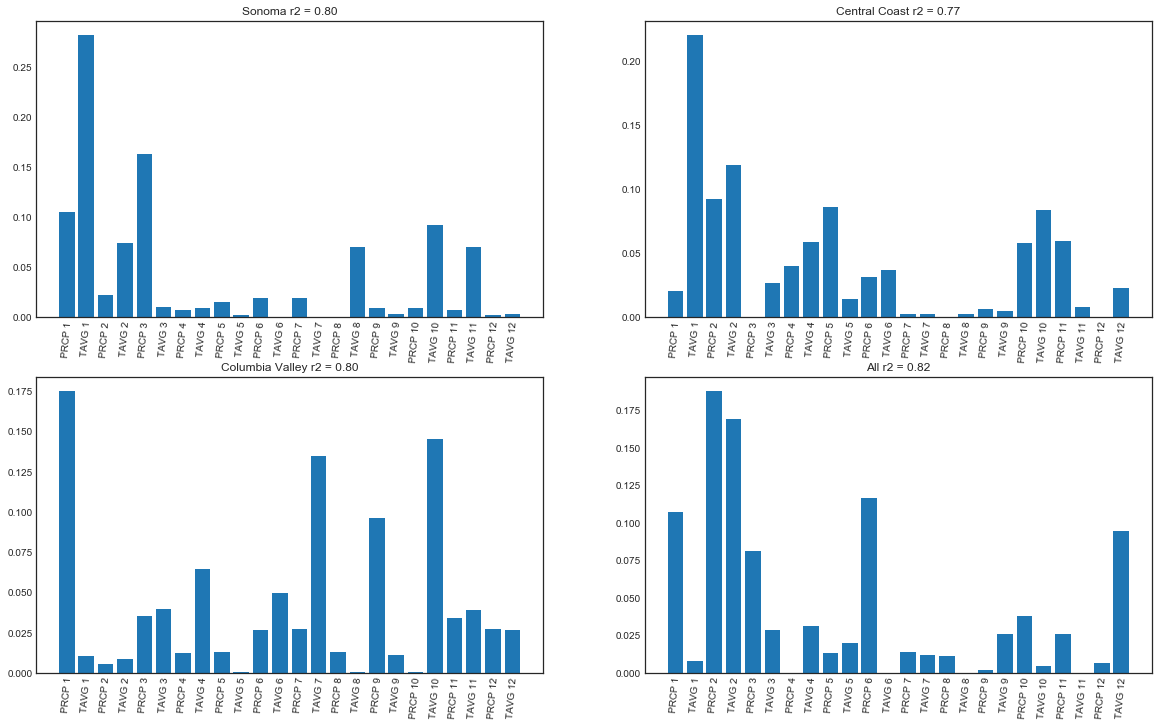

In [164]:
plt.close("all")

fig, axes = plt.subplots(2,2 , figsize = (20,12))
flatax = axes.flatten()
for number, df in enumerate(dfs):
    yeardf = df.groupby("Year").mean()
    
    X = yeardf.iloc[:,2:] #slices of dataframe for machine learning
    y = yeardf.iloc[:,0]
    
    imp = Imputer(missing_values='NaN', strategy='mean', axis=0) #Filling in NaNs with the mean of the column
    imp.fit(X)  #Filling in NaNs with the mean of the column
    X = imp.transform(X)
    
    scaler = StandardScaler() #scaling features 
    X = scaler.fit_transform(X)
    
    
    rf = RandomForestRegressor()
    rf.fit(X,y)
    pred = rf.predict(X)
    
    importances = rf.feature_importances_
    x_values = list(range(len(importances)))
    labels = list(yeardf.iloc[:,2:])
    
    flatax[number].bar(x_values, importances, orientation = 'vertical')
    flatax[number].set_xticks(np.arange(len(importances)))
    flatax[number].set_xticklabels(labels, rotation = 85)
    
    flatax[number].set_title("{0} r2 = {1:.2f}" .format(df.iloc[0,1],r2_score(y,pred)))
flatax[3].set_title("All r2 = {0:.2f}" .format(r2_score(y,pred)) )   
plt.show()

While the r2 values are much better, that is due at least in part to the complicated model overfitting the now relatively fewer examples. There do not appear to be universal trends in the feature importances across the different regions. <br>

Further improvements can be made by expanding to other regions to include more wine, or by changing from Syrah to a more common wine where more data is available. It would also be useful to use weather data more specific to each winery. If the weather data for the zipcode of each winery was used, more model accuracy would almost certainly improve. <br>

While it is certainly expected that the weather would impact that quality of the growing grapes and thus the wine itself, numerous other factors affect the quality of the wine, making it difficult to pinpoint the effect of the weather.